In [23]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder
from PIL import Image
import numpy as np



In [24]:
num_bits = 4
intensity_bits =  2

In [25]:
image = np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]

])

In [59]:
def load_image(filepath, size=(64, 64)):
    img = Image.open(filepath).convert('L')  # Grayscale
    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img)
    return img_array

def normalize_image(image, bits=3):
    max_val = 2**bits - 1
    return np.round((image / 255) * max_val).astype(int)

image = load_image('batman16.jpg',size=(64,64))
image = normalize_image(image, bits=3)
print(image)

[[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]


In [27]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='GradX')
grad_diag = QuantumRegister(intensity_bits, name='GradDiag')
grad2c = QuantumRegister(1, name='GradYc')
grad_diag_c = QuantumRegister(1, name='GradDiagC')
grad_sum_c = QuantumRegister(1, name='GradSumC')
anc = QuantumRegister(1, name='a')
anc2 = QuantumRegister(1, name = 'a2')
anc3 = QuantumRegister(1, name = 'a3')
oracle_a = QuantumRegister(1, name = 'oracle_a')
cr = ClassicalRegister(num_bits*2 + 1, name='c')

qc = QuantumCircuit(x, y, i1, i2, grad1, grad2c, grad_diag, grad_diag_c,grad_sum_c, anc, anc2, anc3, oracle_a, cr)


In [28]:
qc.h(x)
qc.h(y)
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=23, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "GradYc"), index=0>, <Qubit register=(2, "GradDiag"), index=0>, <Qubit register=(2, "GradDiag"), index=1>, <Qubit register=(1, "GradDiagC"), index=0>, <Qubit register=(1, "GradSumC"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "a3"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [29]:
neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))


In [30]:
# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

In [31]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
ladder_down = ladder.inverse()


In [32]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])

In [33]:
sub1 = subtract(i1, grad1, anc)
qc.append(sub1, list(i1) + list(grad1) + list(anc))

In [34]:
neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [35]:
ladder_down = ladder.inverse()
qc.append(ladder, list(y))

In [36]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))

In [37]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad_diag[i])

In [38]:
qc.append(sub1, list(i1) + list(grad_diag) + list(anc3))

In [39]:
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [40]:
qc.append(ladder_down,list(x))
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
qc.append(ladder_down,list(y))


In [41]:
qc.append(sub1, list(i1) + list(i2) + list(anc2))


In [42]:
add = qft_adder(grad1,i2,grad2c)
qc.append(add, list(grad1) + list(i2) + list(grad2c))

In [43]:
add2 = qft_adder(list(i2)+list(grad2c),list(grad_diag)+list(grad_diag_c),grad_sum_c)
qc.append(add2, list(i2)+list(grad2c)+list(grad_diag)+list(grad_diag_c)+list(grad_sum_c))

In [ ]:
qc.barrier()
qc.h(oracle_a)

og = filter_oracle("010")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_a) + list(grad_diag)+list(grad_diag_c))

qc.h(oracle_a)

qc.barrier()

3
[0, 1, 0]
2 0
max 2
1 1
0 0


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=23, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "GradYc"), index=0>, <Qubit register=(2, "GradDiag"), index=0>, <Qubit register=(2, "GradDiag"), index=1>, <Qubit register=(1, "GradDiagC"), index=0>, <Qubit register=(1, "GradSumC"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "a3"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [45]:
qc.measure(list(x) + list(y) + list(oracle_a), list(cr))

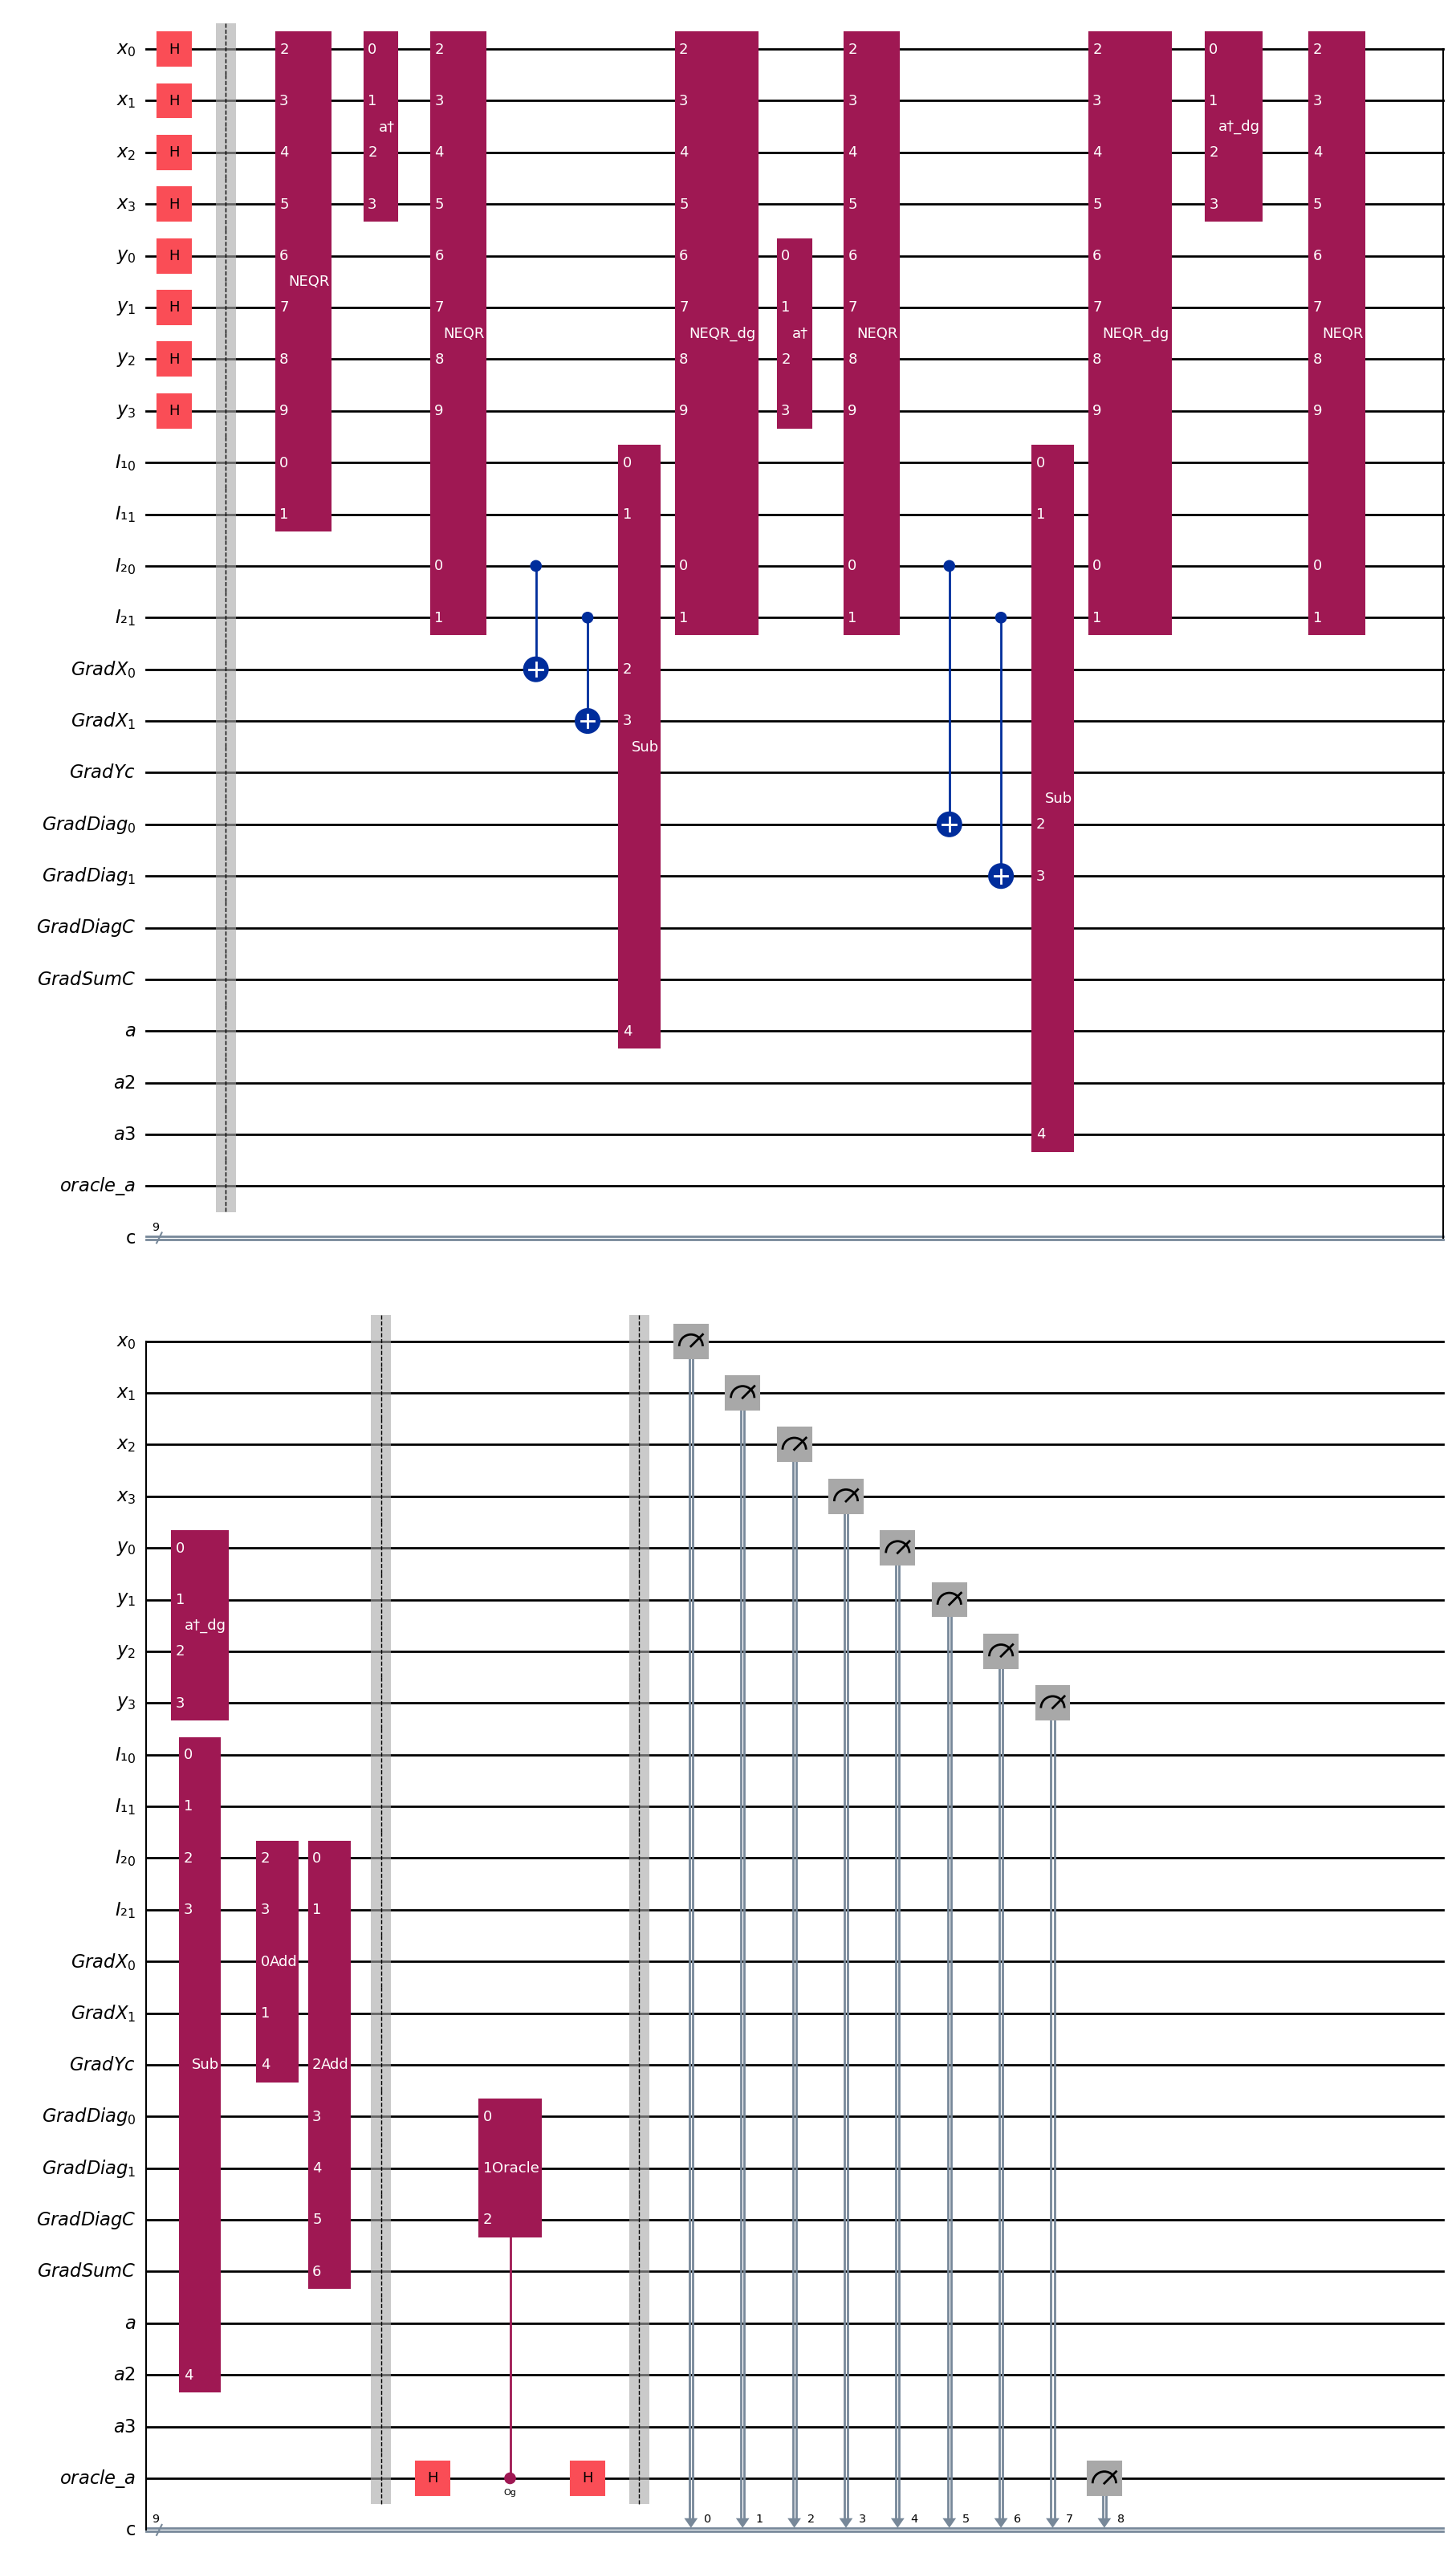

In [46]:
qc.draw('mpl')

In [50]:
simulator = AerSimulator(method='matrix_product_state')
circ = transpile(qc, simulator)

result = simulator.run(circ).result()


In [48]:
counts = result.get_counts()
plot_histogram(counts, title='Bell-State counts')

QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-297 contains invalid parameters  for "extended_stabilizer" method. ,  ERROR: Circuit circuit-297 contains invalid parameters  for "extended_stabilizer" method.'

In [ ]:
print(counts.items())

dict_items([('011010000', 5), ('110110001', 8), ('111011100', 7), ('101000011', 5), ('111000110', 4), ('111110101', 7), ('110011010', 7), ('111000011', 4), ('000011011', 3), ('101010101', 8), ('100100100', 5), ('100011001', 4), ('001111000', 8), ('000100010', 8), ('000111110', 6), ('001001101', 4), ('001010001', 2), ('110101100', 2), ('000111111', 4), ('000100001', 4), ('011101101', 4), ('011010111', 8), ('010111011', 6), ('001010111', 4), ('011100000', 4), ('011001011', 6), ('001111111', 7), ('011110001', 5), ('100101011', 5), ('001101010', 9), ('101111001', 6), ('001011000', 2), ('000110001', 6), ('000101111', 8), ('100111010', 5), ('100100110', 3), ('110000000', 2), ('101101011', 7), ('111100110', 5), ('000101000', 3), ('111000100', 4), ('010110011', 6), ('001011111', 2), ('000010001', 6), ('100110100', 2), ('101011011', 6), ('000010010', 7), ('100110011', 4), ('011110111', 4), ('011010001', 2), ('111101001', 7), ('011000000', 8), ('010000101', 3), ('000001000', 6), ('011100001', 4)

In [ ]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)  
    y = int(y_bin, 2)
    x = int(x_bin, 2)

    edge_img[y, x] = intensity
print(edge_img)

[[0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0]
 [0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0]
 [0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0]
 [1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0]
 [1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0]
 [0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0]
 [0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0]
 [0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0]]


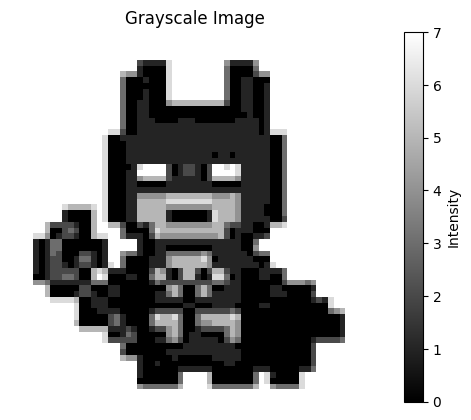

In [60]:
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Grayscale Image')
plt.axis('off')  # Hide axis ticks
plt.show()


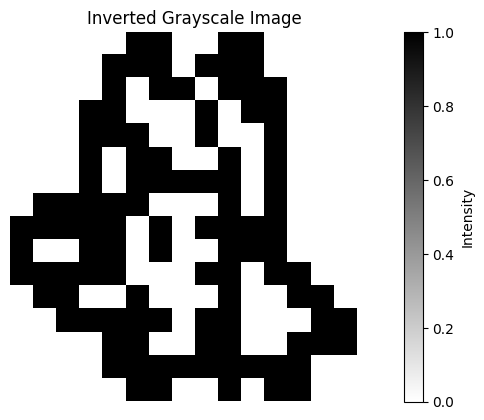

In [ ]:
plt.imshow(edge_img, cmap='gray_r', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Inverted Grayscale Image')
plt.axis('off')
plt.show()